In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tqdm
from sklearn.preprocessing import LabelEncoder

2024-02-25 22:07:23.975245: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-25 22:07:24.274467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 22:07:24.274565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 22:07:24.334975: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-25 22:07:24.453961: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-25 22:07:24.455424: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
!ls train/audio

clip_000044442.wav  clip_40495d123.wav	clip_800388136.wav  clip_bf7c995ed.wav
clip_0000adecb.wav  clip_404a31a66.wav	clip_8003fd409.wav  clip_bf7ca9d7e.wav
clip_0000d4322.wav  clip_404a31d0e.wav	clip_8004e2df3.wav  clip_bf7cb700b.wav
clip_0000fb6fe.wav  clip_404b083f2.wav	clip_8004e47bc.wav  clip_bf7cb74a1.wav
clip_0001d1559.wav  clip_404b67291.wav	clip_800605371.wav  clip_bf7ceff4e.wav
clip_0002256ed.wav  clip_404bcf9e3.wav	clip_80060abe9.wav  clip_bf7d2f10a.wav
clip_0002a4a1f.wav  clip_404ce4fa7.wav	clip_8006d0c14.wav  clip_bf7d43c55.wav
clip_0002d9b83.wav  clip_404d32b96.wav	clip_8006f1935.wav  clip_bf7dae5d1.wav
clip_000373a5b.wav  clip_404d38676.wav	clip_80070761c.wav  clip_bf7e08692.wav
clip_0003c7122.wav  clip_404d3b490.wav	clip_8007b25ce.wav  clip_bf7e0c2c5.wav
clip_0003e6aee.wav  clip_404d45a54.wav	clip_8007c8e18.wav  clip_bf7e6893f.wav
clip_00049951d.wav  clip_404d6e5f0.wav	clip_8007e6696.wav  clip_bf7ee4e85.wav
clip_0004c6707.wav  clip_404dfa282.wav	clip_80084df82.wav  clip_

# Read data

In [2]:
# create json dataset with format: 
# [
#   {
#     "path": "path/to/audio/file",
#     "label": "label"
#   },
#   ...
# ]
path = 'train/audio'
data = []

for label in os.listdir(path):
    for file in os.listdir(f'{path}/{label}'):
        if file == 'README.md':
            continue
        data.append({
            'path': f'{path}/{label}/{file}',
            'label': label
        })

df = pd.DataFrame(data)
df


,path
0,test/audio/clip_726cc12df.wav
1,test/audio/clip_f442b53d8.wav
2,test/audio/clip_ccb6035b1.wav
3,test/audio/clip_fb3a83674.wav
4,test/audio/clip_006f5bc7b.wav
...,...
158533,test/audio/clip_42eb33be8.wav
158534,test/audio/clip_6bb7e3b4c.wav
158535,test/audio/clip_27a90a0cd.wav
158536,test/audio/clip_c6cc2bbe0.wav


# Convert audio to spectrogram

In [3]:
def audio_to_spectrogram(file_path, max_pad_len=174):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    mfcc = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=20)
    pad_width = max_pad_len - mfcc.shape[1]
    if pad_width > 0:
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    return mfcc


In [4]:
# df['spectrogram'] = df['path'].apply(audio_to_spectrogram)
df['spectrogram'] = df['path'] 
for i in tqdm.tqdm(range(len(df))):
    df['spectrogram'][i] = audio_to_spectrogram(df['path'][i])


 21%|██▏       | 34049/158538 [01:51<06:47, 305.64it/s]


KeyboardInterrupt: 

# Split dataset

In [7]:
# split data into train, validation, and test sets

X = np.array(df['spectrogram'].tolist())
X = X[..., np.newaxis]
y = np.array(df['label'].tolist())

# Assuming `y_train` and `y_test` are your categorical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

In [8]:
print(X_train.shape, X_val.shape, X_test.shape)

(41424, 20, 174, 1) (10357, 20, 174, 1) (12946, 20, 174, 1)


# Define model

In [9]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax'),
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 172, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 9, 86, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 84, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 42, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 40, 128)        73856     
                                                                 
 flatten (Flatten)           (None, 5120)              0

In [10]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/10


2024-02-24 16:33:07.762548: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 576622080 exceeds 10% of free system memory.


1295/1295 [==============================] - ETA: 0s - loss: 2.0852 - accuracy: 0.3881

2024-02-24 16:33:39.443951: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 144169440 exceeds 10% of free system memory.


1295/1295 [==============================] - 33s 25ms/step - loss: 2.0852 - accuracy: 0.3881 - val_loss: 0.7798 - val_accuracy: 0.7664
Epoch 2/10
1295/1295 [==============================] - 32s 25ms/step - loss: 0.8257 - accuracy: 0.7542 - val_loss: 0.5446 - val_accuracy: 0.8345
Epoch 3/10
1295/1295 [==============================] - 32s 25ms/step - loss: 0.6182 - accuracy: 0.8168 - val_loss: 0.4880 - val_accuracy: 0.8606
Epoch 4/10
1295/1295 [==============================] - 32s 25ms/step - loss: 0.5106 - accuracy: 0.8509 - val_loss: 0.4703 - val_accuracy: 0.8643
Epoch 5/10
1295/1295 [==============================] - 32s 25ms/step - loss: 0.4468 - accuracy: 0.8682 - val_loss: 0.4627 - val_accuracy: 0.8771
Epoch 6/10
1295/1295 [==============================] - 32s 25ms/step - loss: 0.4116 - accuracy: 0.8791 - val_loss: 0.3855 - val_accuracy: 0.8931
Epoch 7/10
1295/1295 [==============================] - 32s 25ms/step - loss: 0.3776 - accuracy: 0.8902 - val_loss: 0.4124 - val_accura

In [11]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

2024-02-24 16:38:31.029511: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 180208320 exceeds 10% of free system memory.


405/405 - 2s - loss: 0.4521 - accuracy: 0.8877 - 2s/epoch - 5ms/step

Test accuracy: 0.8876873254776001


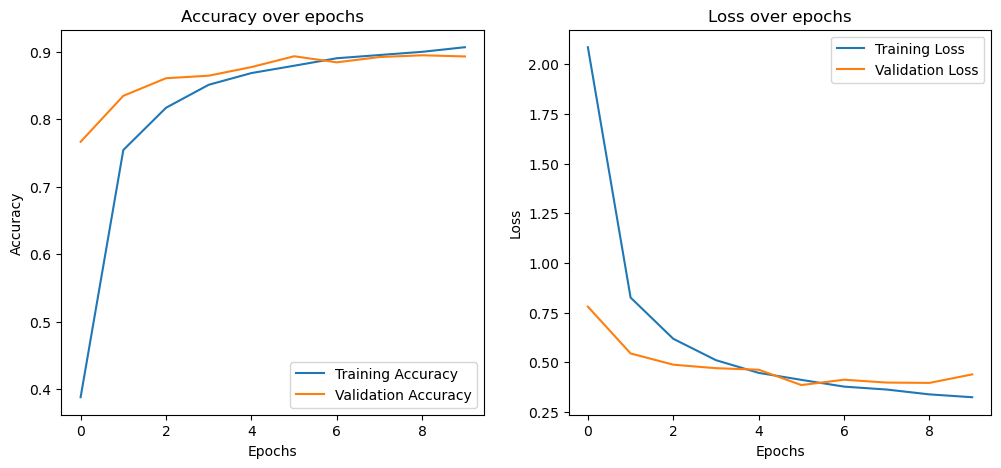

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [13]:
model.save('model.h5')

/home/huy/miniconda3/envs/distill/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
